In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import geopandas as gpd

plt.style.use('ggplot')
pd.set_option('display.max_columns', 30)

In [2]:
df = pd.read_csv('data/citibike_ZIP.csv')
df.head()

,tripduration,starttime,stoptime,start_id,start_name,start_lat,start_lon,end_id,end_name,end_lat,end_lon,bikeid,usertype,birth_year,gender,weekday,hour,geometry,zip_start,zip_end
0,17.700000,2020-06-01 00:00:03.372,2020-06-01 00:17:46.208,3419,Douglass St & 4 Ave,40.679279,-73.981540,3419,Douglass St & 4 Ave,40.679279,-73.981540,39852,Customer,1997,2,0,0,POINT (989370.1838770027 186756.53892500512),11217,11217.0
1,63.500000,2020-06-01 00:00:03.553,2020-06-01 01:03:33.936,366,Clinton Ave & Myrtle Ave,40.693261,-73.968896,336,Sullivan St & Washington Sq,40.730477,-73.999061,37558,Subscriber,1969,0,0,0,POINT (992875.4144866021 191851.65323921342),11205,10012.0
2,16.950000,2020-06-01 00:00:09.614,2020-06-01 00:17:06.833,389,Broadway & Berry St,40.710446,-73.965251,3562,Classon Ave & St Marks Ave,40.676520,-73.959608,37512,Customer,1988,2,0,0,POINT (993883.8241576733 198112.87322040228),11249,11238.0
3,3.766667,2020-06-01 00:00:12.178,2020-06-01 00:03:58.864,3255,8 Ave & W 31 St,40.750585,-73.994685,505,6 Ave & W 33 St,40.749013,-73.988484,39674,Customer,1969,0,0,0,POINT (985722.6805079061 212735.19209770544),10001,10001.0
4,23.950000,2020-06-01 00:00:21.255,2020-06-01 00:24:18.965,367,E 53 St & Lexington Ave,40.758281,-73.970694,497,E 17 St & Broadway,40.737050,-73.990093,21093,Customer,1997,2,0,0,POINT (992368.8021711168 215540.1540624901),10022,10003.0


In [3]:
# supply and demand

starts_hrly = df.groupby(['hour','zip_start'], as_index = False)[['bikeid']].count()
starts_hrly.columns = ['hour','zip_start','start_count']
starts_hrly

,hour,zip_start,start_count
0,0,83,274
1,0,10001,554
2,0,10002,705
3,0,10003,811
4,0,10004,68
...,...,...,...
1717,23,11237,289
1718,23,11238,525
1719,23,11249,800
1720,23,11251,29


In [4]:
ends_hrly = df.groupby(['hour','zip_end'], as_index = False)[['bikeid']].count()
ends_hrly.columns = ['hour','zip_end','end_count']
ends_hrly

,hour,zip_end,end_count
0,0,83.0,213
1,0,10001.0,562
2,0,10002.0,762
3,0,10003.0,785
4,0,10004.0,82
...,...,...,...
1717,23,11237.0,321
1718,23,11238.0,531
1719,23,11249.0,482
1720,23,11251.0,37


In [5]:
supply_hrly = starts_hrly.merge(ends_hrly,
                               left_on = ['hour','zip_start'],
                               right_on = ['hour','zip_end'],
                               how = 'outer')
supply_hrly.head(10)

,hour,zip_start,start_count,zip_end,end_count
0,0,83.0,274.0,83.0,213.0
1,0,10001.0,554.0,10001.0,562.0
2,0,10002.0,705.0,10002.0,762.0
3,0,10003.0,811.0,10003.0,785.0
4,0,10004.0,68.0,10004.0,82.0
5,0,10005.0,118.0,10005.0,124.0
6,0,10007.0,201.0,10007.0,175.0
7,0,10009.0,623.0,10009.0,675.0
8,0,10010.0,156.0,10010.0,191.0
9,0,10011.0,626.0,10011.0,549.0


In [6]:
supply_hrly['end_count'].fillna(0, inplace=True)
supply_hrly['start_count'].fillna(0, inplace=True)

In [8]:
# define hourly surplus as the difference between hourly end count and start count at a station
# find daily average by dividing by 28

supply_hrly['hrly_surplus'] = (supply_hrly['end_count'] - supply_hrly['start_count'])/30
supply_hrly.head()

,hour,zip_start,start_count,zip_end,end_count,hrly_surplus
0,0,83.0,274.0,83.0,213.0,-2.033333
1,0,10001.0,554.0,10001.0,562.0,0.266667
2,0,10002.0,705.0,10002.0,762.0,1.900000
3,0,10003.0,811.0,10003.0,785.0,-0.866667
4,0,10004.0,68.0,10004.0,82.0,0.466667


In [9]:
d = supply_hrly.groupby('hour', as_index = False)[['hrly_surplus']].agg(['mean','min','max'])
d = d['hrly_surplus'].reset_index()
d

,hour,mean,min,max
0,0,3.083953e-18,-11.533333,3.533333
1,1,3.083953e-18,-3.600000,2.100000
2,2,-6.938894e-18,-1.733333,1.733333
3,3,9.912706e-20,-1.333333,0.866667
4,4,-2.247811e-18,-1.500000,1.700000
5,5,1.850372e-17,-8.166667,9.600000
6,6,-2.775558e-17,-24.900000,47.566667
7,7,-1.480297e-16,-25.766667,39.433333
8,8,-6.784696e-17,-32.600000,37.333333
9,9,9.251859e-17,-37.366667,21.333333


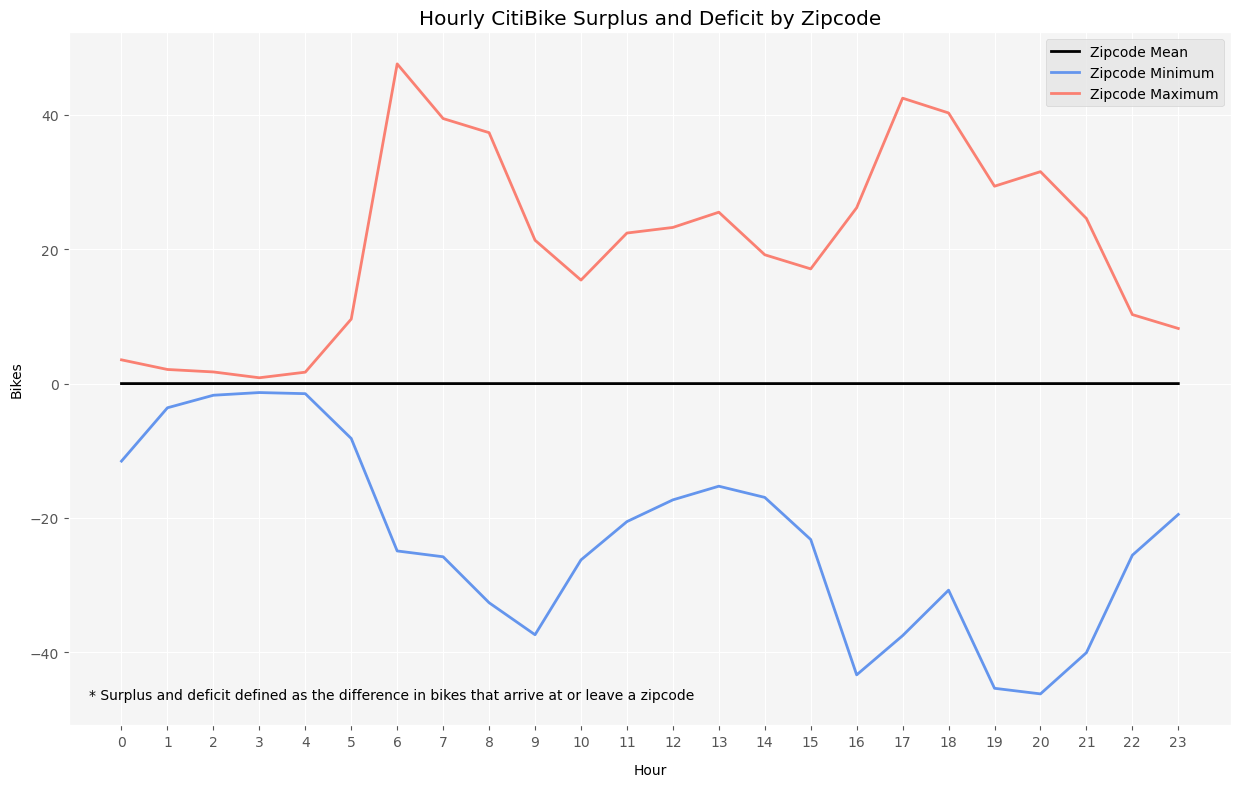

In [13]:
fig, ax = plt.subplots(figsize=(15,9)) # w x h

x = np.arange(24)
  
d.plot(ax=ax, x = 'hour', y = 'mean', color = 'black', linewidth = 2)
d.plot(ax=ax, x = 'hour', y = 'min', color = 'cornflowerblue', linewidth = 2)
d.plot(ax=ax, x = 'hour', y = 'max', color = 'salmon', linewidth = 2)

plt.xticks(x)
plt.xlabel("Hour", labelpad = 10)
plt.ylabel("Bikes")
plt.text(-0.7, -47, '* Surplus and deficit defined as the difference in bikes that arrive at or leave a zipcode')
plt.legend(['Zipcode Mean', 'Zipcode Minimum', 'Zipcode Maximum'])

plt.title('Hourly CitiBike Surplus and Deficit by Zipcode')
ax.set_facecolor("whitesmoke")